<a href="https://colab.research.google.com/github/AlexanderDadaev/code_related/blob/master/cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Using Convolutional Neural Network to Identify Dogs vs Cats
#https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"udt25kaggle","key":"3476ba1c30520d6f16027f3fc0f596d3"}'}

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Nov 26 02:51 kaggle.json


In [0]:
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Copy the stackoverflow data set locally.
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 97% 264M/271M [00:02<00:00, 126MB/s]
100% 271M/271M [00:02<00:00, 140MB/s]
 98% 531M/544M [00:05<00:00, 138MB/s]
100% 544M/544M [00:05<00:00, 112MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 99.7MB/s]


In [0]:
#manually change directory: !kaggle competitions download  -c titanic -p /content/kaggle
#stored here: data = pd.read_csv('/content/kaggle/train.csv')
import pandas as pd
data = pd.read_csv('/content/sample_submission.csv')
data.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [0]:
!unzip '/content/test.zip'
!unzip '/content/train.zip'

Archive:  /content/test.zip
   creating: test/
  inflating: test/1.jpg              
  inflating: test/10.jpg             
  inflating: test/100.jpg            
  inflating: test/1000.jpg           
  inflating: test/10000.jpg          
  inflating: test/10001.jpg          
  inflating: test/10002.jpg          
  inflating: test/10003.jpg          
  inflating: test/10004.jpg          
  inflating: test/10005.jpg          
  inflating: test/10006.jpg          
  inflating: test/10007.jpg          
  inflating: test/10008.jpg          
  inflating: test/10009.jpg          
  inflating: test/1001.jpg           
  inflating: test/10010.jpg          
  inflating: test/10011.jpg          
  inflating: test/10012.jpg          
  inflating: test/10013.jpg          
  inflating: test/10014.jpg          
  inflating: test/10015.jpg          
  inflating: test/10016.jpg          
  inflating: test/10017.jpg          
  inflating: test/10018.jpg          
  inflating: test/10019.jpg          
  i

In [0]:
#importing required libs
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

train_dir = '/content/train/'
test_dir = '/content/test/'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic')

In [0]:
def label_img(img):
  # conversion to one-hot array [cat,dog]
  word_label = img.split('.')[-3]
  if word_label == 'cat': return [1,0] #[much cat, no dog]
  elif word_label == 'dog': return [0,1] #[no cat, very doggo]

In [0]:
def create_train_data():
  training_data = []
  for img in tqdm(os.listdir(train_dir)):
    label = label_img(img) 
    path = os.path.join(train_dir, img)
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    training_data.append([np.array(img),np.array(label)])
  shuffle(training_data)
  np.save('train_data.npy', training_data)
  return training_data

In [0]:
def process_test_data():
  testing_data = []
  for img in tqdm(os.listdir(test_dir)):
    path = os.path.join(test_dir,img)
    img_num = img.split('.')[0]
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    testing_data.append([np.array(img), img_num])

  shuffle(testing_data)
  np.save('test_data.npy', testing_data)
  return testing_data

In [0]:
train_data = create_train_data()
# if you already have train data:
# train_data = np.load('train_data.npy')

100%|██████████| 25000/25000 [00:26<00:00, 927.06it/s]


In [0]:
!pip install tflearn
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [0]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [0]:
#train train data split
train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [0]:
import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.52613 | time: 99.922s
| Adam | epoch: 003 | loss: 0.52613 - acc: 0.7284 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.52909 | time: 101.182s
| Adam | epoch: 003 | loss: 0.52909 - acc: 0.7258 | val_loss: 0.49365 - val_acc: 0.7500 -- iter: 24500/24500
--


In [0]:
model.save(MODEL_NAME)

INFO:tensorflow:/content/dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:13<00:00, 933.33it/s]


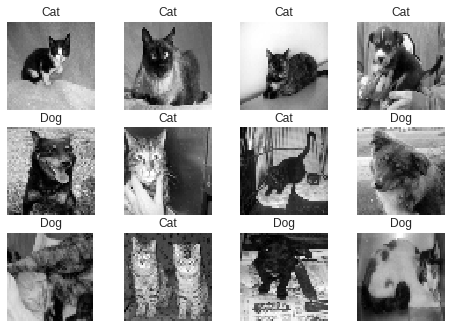

In [0]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [0]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
    
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [00:34<00:00, 363.98it/s]
